### 1. DNN을 통한 분류

#### ※ 앞으로 궁금할 상식: 분류 학습에서 왜 Cross Entropy를 사용할 때, output layer에 activation function을 안쓰는걸까?
* (Binary) Cross Entropy에 이미 activation(예: sigmoid, softmax)이 내재되어 있어, 1차로 output의 features(Not categorical)를 activation 해준 후에, 2차로 CE loss 계산

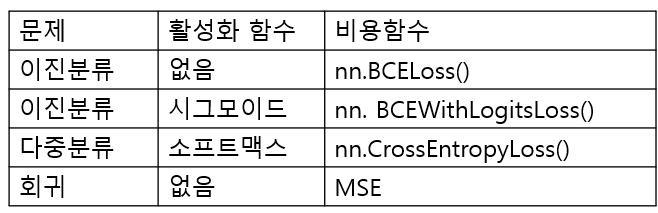

### 2. wine.csv 데이터셋 기반 DNN 이진분류

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('wine.csv')

# 화이트 와인(0)인지 레드와인(1)인지
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # 2차원으로 만들어야함. 모델 예측은 2차원으로 나오기 때문
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, 16)
        self.layer4 = nn.Linear(16, 8)
        self.layer5 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.layer5(x)
        return x

input_dim = X_train.shape[1]
model = DNN(input_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred = torch.sigmoid(y_pred) # 시그모이드를 통과해서 확률값 구함
        y_pred = (y_pred > 0.5).float()
        correct += (y_pred == y_batch).sum().item() # 맞춘값들을 더한다음에
        total += y_batch.size(0) # 해당 미니배치 데이터 셋 개수를 구해 놓고

    accuracy = correct / total   # 맞춘 것들 누적 / 미니배치 데이터셋 갯수 누적
    print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 0.0791
Epoch 2/10, Loss: 0.0109
Epoch 3/10, Loss: 0.0582
Epoch 4/10, Loss: 0.0055
Epoch 5/10, Loss: 0.0112
Epoch 6/10, Loss: 0.0036
Epoch 7/10, Loss: 0.0043
Epoch 8/10, Loss: 0.0040
Epoch 9/10, Loss: 0.0045
Epoch 10/10, Loss: 0.0033
Accuracy: 0.9969


### 실습) wine.csv 데이터셋 기반 DNN 이진분류를 누군가 코드를 망쳐놨다. 고쳐보자

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('wine.csv')

# 화이트 와인(0)인지 레드와인(1)인지
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # 2차원으로 만들어야함. 모델 예측은 2차원으로 나오기 때문
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.bn = nn.BatchNorm1d(16)
        self.do = nn.Dropout(0.5)
        self.layer3 = nn.Linear(16, 16)
        self.layer4 = nn.Linear(16, 8)
        self.layer5 = nn.Linear(8, 1)  # 수정
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.bn(self.layer2(x)))
        x = self.do(x)
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.layer5(x)
        return x

input_dim = X_train.shape[1]
model = DNN(input_dim)

criterion = nn.BCEWithLogitsLoss()           # 수정
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred = torch.sigmoid(y_pred)   # 시그모이드를 통과해서 확률값 구함  # 수정
        y_pred = (y_pred > 0.5).float() # 수정
        correct += (y_pred == y_batch).sum().item() # 수정
        total += y_batch.size(0)

    accuracy = correct / total# 수정
    print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10, Loss: 0.1878
Epoch 2/10, Loss: 0.0249
Epoch 3/10, Loss: 0.0894
Epoch 4/10, Loss: 0.0149
Epoch 5/10, Loss: 0.0079
Epoch 6/10, Loss: 0.0837
Epoch 7/10, Loss: 0.0039
Epoch 8/10, Loss: 0.0425
Epoch 9/10, Loss: 0.0113
Epoch 10/10, Loss: 0.0211
Accuracy: 0.9985


### 3. wine.csv 데이터셋 기반 DNN 이진분류

1). accracy

2). f1_score

3). confusion matrix

4). precision

5). recall

을 출력해보자

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

df = pd.read_csv('wine.csv')

# 화이트 와인(0)인지 레드와인(1)인지
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # 2차원으로 만들어야함. 모델 예측은 2차원으로 나오기 때문
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, 16)
        self.layer4 = nn.Linear(16, 8)
        self.layer5 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.layer5(x)
        return x

input_dim = X_train.shape[1]
model = DNN(input_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_preds = []
    y_trues = []
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred = torch.sigmoid(y_pred)  # 시그모이드를 통과해서 확률값 구함
        y_pred = (y_pred > 0.5).float()  # 0.5를 기준으로 이진화
        # 0 또는 1로 최종 결과 값으로 바꿈
        y_preds.extend(y_pred.view(-1).tolist()) # 예측값 1d 리스트 타입으로 바꿈
        y_trues.extend(y_batch.view(-1).tolist()) # 정답값 1d 리스트 타입으로 바꿈

    # 성능 지표 계산
    accuracy = accuracy_score(y_trues, y_preds)
    f1 = f1_score(y_trues, y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    precision = precision_score(y_trues, y_preds)
    recall = recall_score(y_trues, y_preds)

    # 결과 출력
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')


Epoch 1/10, Loss: 0.0385
Epoch 2/10, Loss: 0.0117
Epoch 3/10, Loss: 0.0067
Epoch 4/10, Loss: 0.0045
Epoch 5/10, Loss: 0.0040
Epoch 6/10, Loss: 0.0021
Epoch 7/10, Loss: 0.0037
Epoch 8/10, Loss: 0.0026
Epoch 9/10, Loss: 0.0032
Epoch 10/10, Loss: 0.0009
Accuracy: 0.9977
F1 Score: 0.9953
Confusion Matrix:
[[980   0]
 [  3 317]]
Precision: 1.0000
Recall: 0.9906


### 4. wine.csv 데이터셋 기반 DNN 이진분류 - 클래스 불균형 해결

SMOTE를 사용해보자

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

df = pd.read_csv('wine.csv')
df['class'].value_counts()

,count
class,
0,4898
1,1599


In [ ]:
from imblearn.over_sampling import SMOTE

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values   # 화이트 와인: 0, 레드 와인: 1

# 데이터셋 분리 (훈련 및 테스트 셋)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# SMOTE 적용 후 클래스 분포 확인
print(f"After SMOTE: \n{pd.Series(y_train_resampled).value_counts()}")

After SMOTE: 
0    3918
1    3918
Name: count, dtype: int64


In [ ]:
# 데이터 정규화
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# 데이터를 텐서로 변환
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)  # 2차원으로 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 데이터셋과 데이터로더 준비
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# DNN 모델 정의
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, 16)
        self.layer4 = nn.Linear(16, 8)
        self.layer5 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.layer5(x)
        return x

input_dim = X_train.shape[1]
model = DNN(input_dim)

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 모델 평가
model.eval()
with torch.no_grad():
    y_preds = []
    y_trues = []
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred = torch.sigmoid(y_pred)  # 시그모이드를 통과해서 확률값 구함
        y_pred = (y_pred > 0.5).float()  # 0.5를 기준으로 이진화
        y_preds.extend(y_pred.view(-1).tolist())
        y_trues.extend(y_batch.view(-1).tolist())

    # 성능 지표 계산
    accuracy = accuracy_score(y_trues, y_preds)
    f1 = f1_score(y_trues, y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    precision = precision_score(y_trues, y_preds)
    recall = recall_score(y_trues, y_preds)

    # 결과 출력
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

Epoch 1/10, Loss: 0.0104
Epoch 2/10, Loss: 0.0188
Epoch 3/10, Loss: 0.0026
Epoch 4/10, Loss: 0.0109
Epoch 5/10, Loss: 0.0151
Epoch 6/10, Loss: 0.0056
Epoch 7/10, Loss: 0.0038
Epoch 8/10, Loss: 0.0066
Epoch 9/10, Loss: 0.0020
Epoch 10/10, Loss: 0.0014
Accuracy: 0.9985
F1 Score: 0.9969
Confusion Matrix:
[[980   0]
 [  2 318]]
Precision: 1.0000
Recall: 0.9938


### 같이해보는 실습) 타이타닉 데이터셋으로 MLP 모델을 이용하여 생존분류를 해보자  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv('titanic.csv')
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
df.dropna(inplace=True) # nan 값이면 삭제하고 실제로 반영해라.

# 범주형 컬럼 라벨 인코더로 숫자로 바꿈
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

# 장딥깂 뻬거 X정의
X = df.drop('Survived', axis=1).values

# 정답값만 가져오기
y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

input_dim = X_train.shape[1]
model = MLP(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred = (y_pred > 0.5).float()
        correct += (y_pred == y_batch).sum().item()
        total += y_batch.size(0)

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')


Epoch 1/50, Loss: 0.6616
Epoch 2/50, Loss: 0.5673
Epoch 3/50, Loss: 0.4741
Epoch 4/50, Loss: 0.5051
Epoch 5/50, Loss: 0.5547
Epoch 6/50, Loss: 0.3293
Epoch 7/50, Loss: 0.4114
Epoch 8/50, Loss: 0.4188
Epoch 9/50, Loss: 0.3888
Epoch 10/50, Loss: 0.4796
Epoch 11/50, Loss: 0.4046
Epoch 12/50, Loss: 0.3640
Epoch 13/50, Loss: 0.3355
Epoch 14/50, Loss: 0.5538
Epoch 15/50, Loss: 0.3394
Epoch 16/50, Loss: 0.6072
Epoch 17/50, Loss: 0.3192
Epoch 18/50, Loss: 0.3856
Epoch 19/50, Loss: 0.4850
Epoch 20/50, Loss: 0.3366
Epoch 21/50, Loss: 0.2038
Epoch 22/50, Loss: 0.2291
Epoch 23/50, Loss: 0.4473
Epoch 24/50, Loss: 0.3333
Epoch 25/50, Loss: 0.3245
Epoch 26/50, Loss: 0.4182
Epoch 27/50, Loss: 0.3505
Epoch 28/50, Loss: 0.5480
Epoch 29/50, Loss: 0.3347
Epoch 30/50, Loss: 0.4798
Epoch 31/50, Loss: 0.3856
Epoch 32/50, Loss: 0.6020
Epoch 33/50, Loss: 0.5367
Epoch 34/50, Loss: 0.5913
Epoch 35/50, Loss: 0.5574
Epoch 36/50, Loss: 0.4063
Epoch 37/50, Loss: 0.4017
Epoch 38/50, Loss: 0.3560
Epoch 39/50, Loss: 0.

### 5. 타이타닉 데이터셋으로 MLP 모델을 이용하여 생존분류를 해보자 - 클래스 불균형 해결

SMOTENC를 사용해보자

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, SMOTENC

# 데이터 로드 및 전처리
df = pd.read_csv('titanic.csv')
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
df.dropna(inplace=True)

# 각 클래스가 몇개인지 보자
print(df['Survived'].value_counts())

Survived
0    424
1    288
Name: count, dtype: int64


In [ ]:
# 범주형 변수 인코딩
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

X = df.drop('Survived', axis=1).values
y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 범주형 변수 인덱스 (Pclass, Sex, Embarked)
categorical_features = [0, 1, 4]

# SMOTE-NC 적용
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# 범주형과 수치형 변수를 고려하여 클래스 균형에 맞게 데이터를 upsampling 한 결과
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# 정규화
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# 텐서변환
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

input_dim = X_train.shape[1]
model = MLP(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 모델 평가
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred = (y_pred > 0.5).float()
        correct += (y_pred == y_batch).sum().item()
        total += y_batch.size(0)

    accuracy = correct / total


Epoch 1/50, Loss: 0.6449
Epoch 2/50, Loss: 0.6431
Epoch 3/50, Loss: 0.4418
Epoch 4/50, Loss: 0.3589
Epoch 5/50, Loss: 0.9187
Epoch 6/50, Loss: 0.1516
Epoch 7/50, Loss: 0.9077
Epoch 8/50, Loss: 0.6966
Epoch 9/50, Loss: 0.8003
Epoch 10/50, Loss: 0.5094
Epoch 11/50, Loss: 0.2824
Epoch 12/50, Loss: 0.3887
Epoch 13/50, Loss: 0.5105
Epoch 14/50, Loss: 0.1298
Epoch 15/50, Loss: 0.3165
Epoch 16/50, Loss: 0.5192
Epoch 17/50, Loss: 0.3865
Epoch 18/50, Loss: 0.2219
Epoch 19/50, Loss: 0.4391
Epoch 20/50, Loss: 0.6284
Epoch 21/50, Loss: 0.1346
Epoch 22/50, Loss: 0.4916
Epoch 23/50, Loss: 0.5132
Epoch 24/50, Loss: 0.6216
Epoch 25/50, Loss: 0.3604
Epoch 26/50, Loss: 0.2388
Epoch 27/50, Loss: 0.3396
Epoch 28/50, Loss: 0.3088
Epoch 29/50, Loss: 0.4923
Epoch 30/50, Loss: 0.3203
Epoch 31/50, Loss: 0.4070
Epoch 32/50, Loss: 0.4906
Epoch 33/50, Loss: 0.4804
Epoch 34/50, Loss: 0.3925
Epoch 35/50, Loss: 0.3808
Epoch 36/50, Loss: 0.3309
Epoch 37/50, Loss: 0.5575
Epoch 38/50, Loss: 0.2351
Epoch 39/50, Loss: 0.

### 3. iris.csv 데이터셋 기반 MLP 다중분류

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score

df = pd.read_csv('iris.csv')
df['variety'] = LabelEncoder().fit_transform(df['variety'])
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

'''
# 방법 1: nn.Sequential()과 add_module 사용

model = nn.Sequential()
model.add_module('fc1', nn.Linear(4, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 3))

# 방법 2: nn.Sequential() 안에 직접 레이어 정의
model = nn.Sequential(
     nn.Linear(4, 100),  # input_layer = 784, hidden_layer1 = 100
     nn.ReLU(),
     nn.Linear(100, 100),  # hidden_layer2 = 100, hidden_layer3 = 100
     nn.ReLU(),
     nn.Linear(100, 3)  # hidden_layer3 = 100, output_layer = 10
     )
'''
# 방법 3: nn.Module을 상속하는 클래스 정의
class MultiLayerRegression(nn.Module):
    def __init__(self):
        super(MultiLayerRegression, self).__init__()
                                # X_train에 데이터 X 피처갯수와 shape을 가지는데 거기에 인덱스 1(피처갯수)
        self.linear1 = nn.Linear(X_train.shape[1], 100)  # input_layer = X_train.shape[1], hidden_layer1 = 100
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 100)  # hidden_layer2 = 100, hidden_layer3 = 100
        self.activate2 = nn.ReLU()
                                      # 범주형 정답값에서 유니크 셋 (즉, 버시컬러, 세토사, 버지니카 의 깊이)
        self.linear3 = nn.Linear(100, len(set(y)))  # hidden_layer3 = 100, output_layer = len(set(y))

    def forward(self, x):
        out1 = self.linear1(x)
        out2 = self.activate1(out1)
        out3 = self.linear2(out2)
        out4 = self.activate2(out3)
        out5 = self.linear3(out4)
        return out5

model = MultiLayerRegression()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

patience = 5
best_loss = float('inf')
early_stop_counter = 0

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')


Epoch 1/50, Loss: 0.9508, Val Loss: 0.9508
Epoch 2/50, Loss: 0.8338, Val Loss: 0.8338
Epoch 3/50, Loss: 0.7329, Val Loss: 0.7329
Epoch 4/50, Loss: 0.6485, Val Loss: 0.6485
Epoch 5/50, Loss: 0.5788, Val Loss: 0.5788
Epoch 6/50, Loss: 0.5220, Val Loss: 0.5220
Epoch 7/50, Loss: 0.4764, Val Loss: 0.4764
Epoch 8/50, Loss: 0.4379, Val Loss: 0.4379
Epoch 9/50, Loss: 0.4012, Val Loss: 0.4012
Epoch 10/50, Loss: 0.3700, Val Loss: 0.3700
Epoch 11/50, Loss: 0.3419, Val Loss: 0.3419
Epoch 12/50, Loss: 0.3169, Val Loss: 0.3169
Epoch 13/50, Loss: 0.2947, Val Loss: 0.2947
Epoch 14/50, Loss: 0.2751, Val Loss: 0.2751
Epoch 15/50, Loss: 0.2564, Val Loss: 0.2564
Epoch 16/50, Loss: 0.2392, Val Loss: 0.2392
Epoch 17/50, Loss: 0.2217, Val Loss: 0.2217
Epoch 18/50, Loss: 0.2062, Val Loss: 0.2062
Epoch 19/50, Loss: 0.1905, Val Loss: 0.1905
Epoch 20/50, Loss: 0.1762, Val Loss: 0.1762
Epoch 21/50, Loss: 0.1640, Val Loss: 0.1640
Epoch 22/50, Loss: 0.1531, Val Loss: 0.1531
Epoch 23/50, Loss: 0.1434, Val Loss: 0.14

# ★ 실무 실습) 배포 받은 "신용카드 사용자 연체 예측"를 통해 자신만의 코드를 작성 해보자

[사람의 정보를 넣어서 신용을 분류예측 하는 모델을 만들어 보자!]

1. credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도 (0,1,2)=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

2. 하나의 포트폴리오가 될 수 있도록 시각화와 통계를 자유롭게 작성해보자.
3. 이제까지 배운 분류 방법들을 통해 적용해보자.
4. 모든 기법을 다 쓰는 것보다는 필요 할 것 같다는 코드만 작성해보기

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score
df = pd.read_csv('train.csv')
df['occyp_type'].fillna('None', inplace = True)
df.drop(columns = 'index', inplace = True)

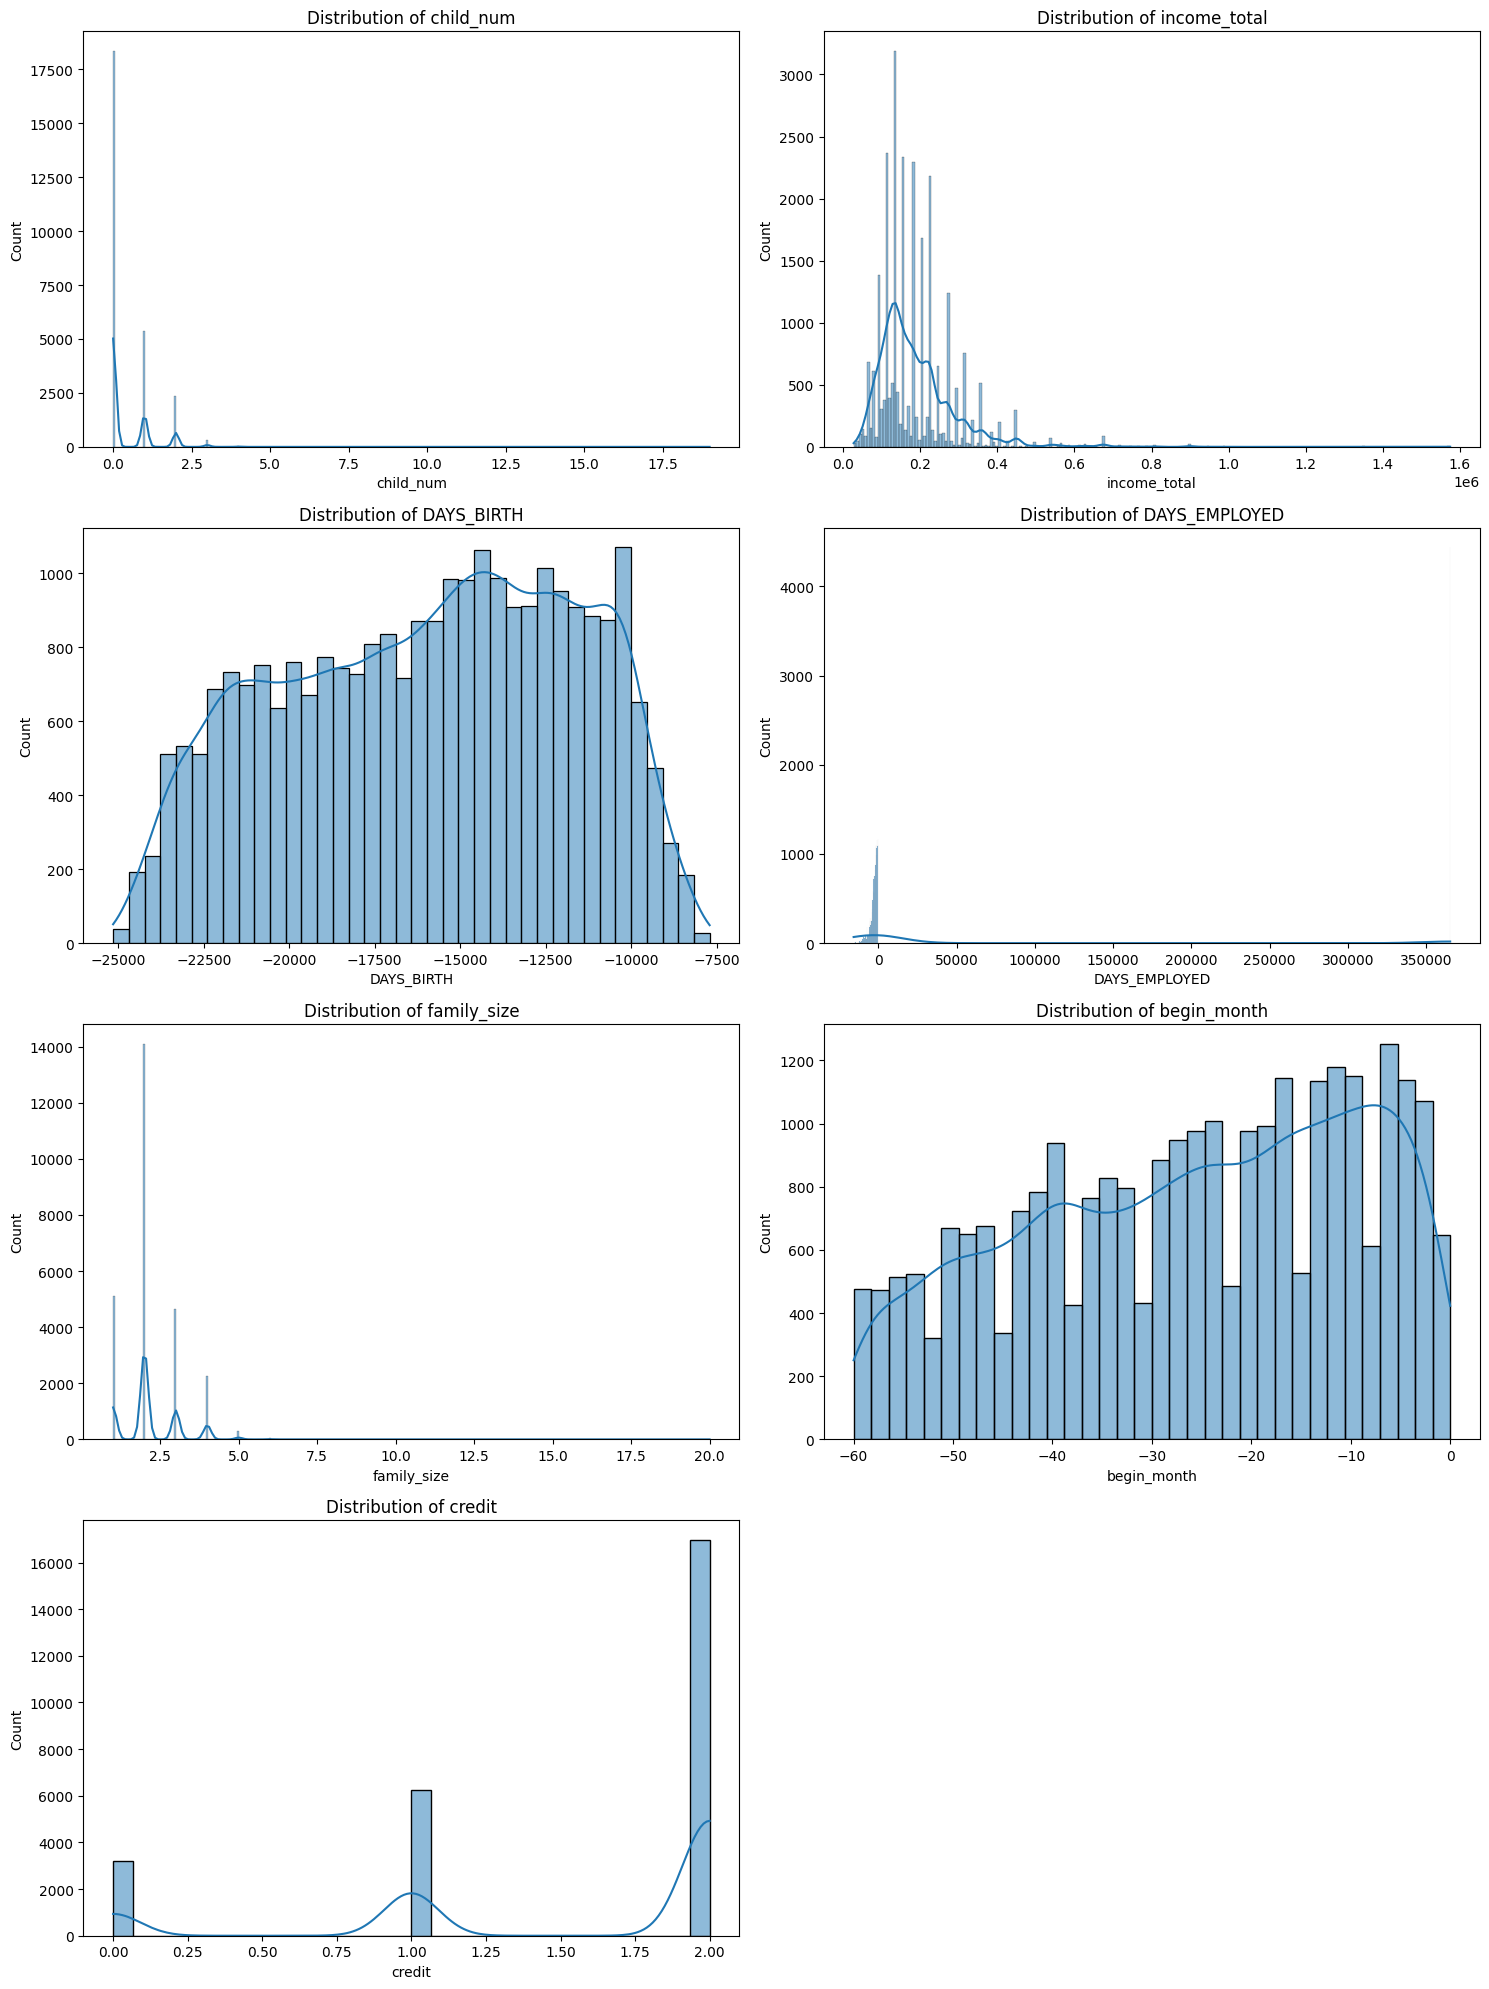

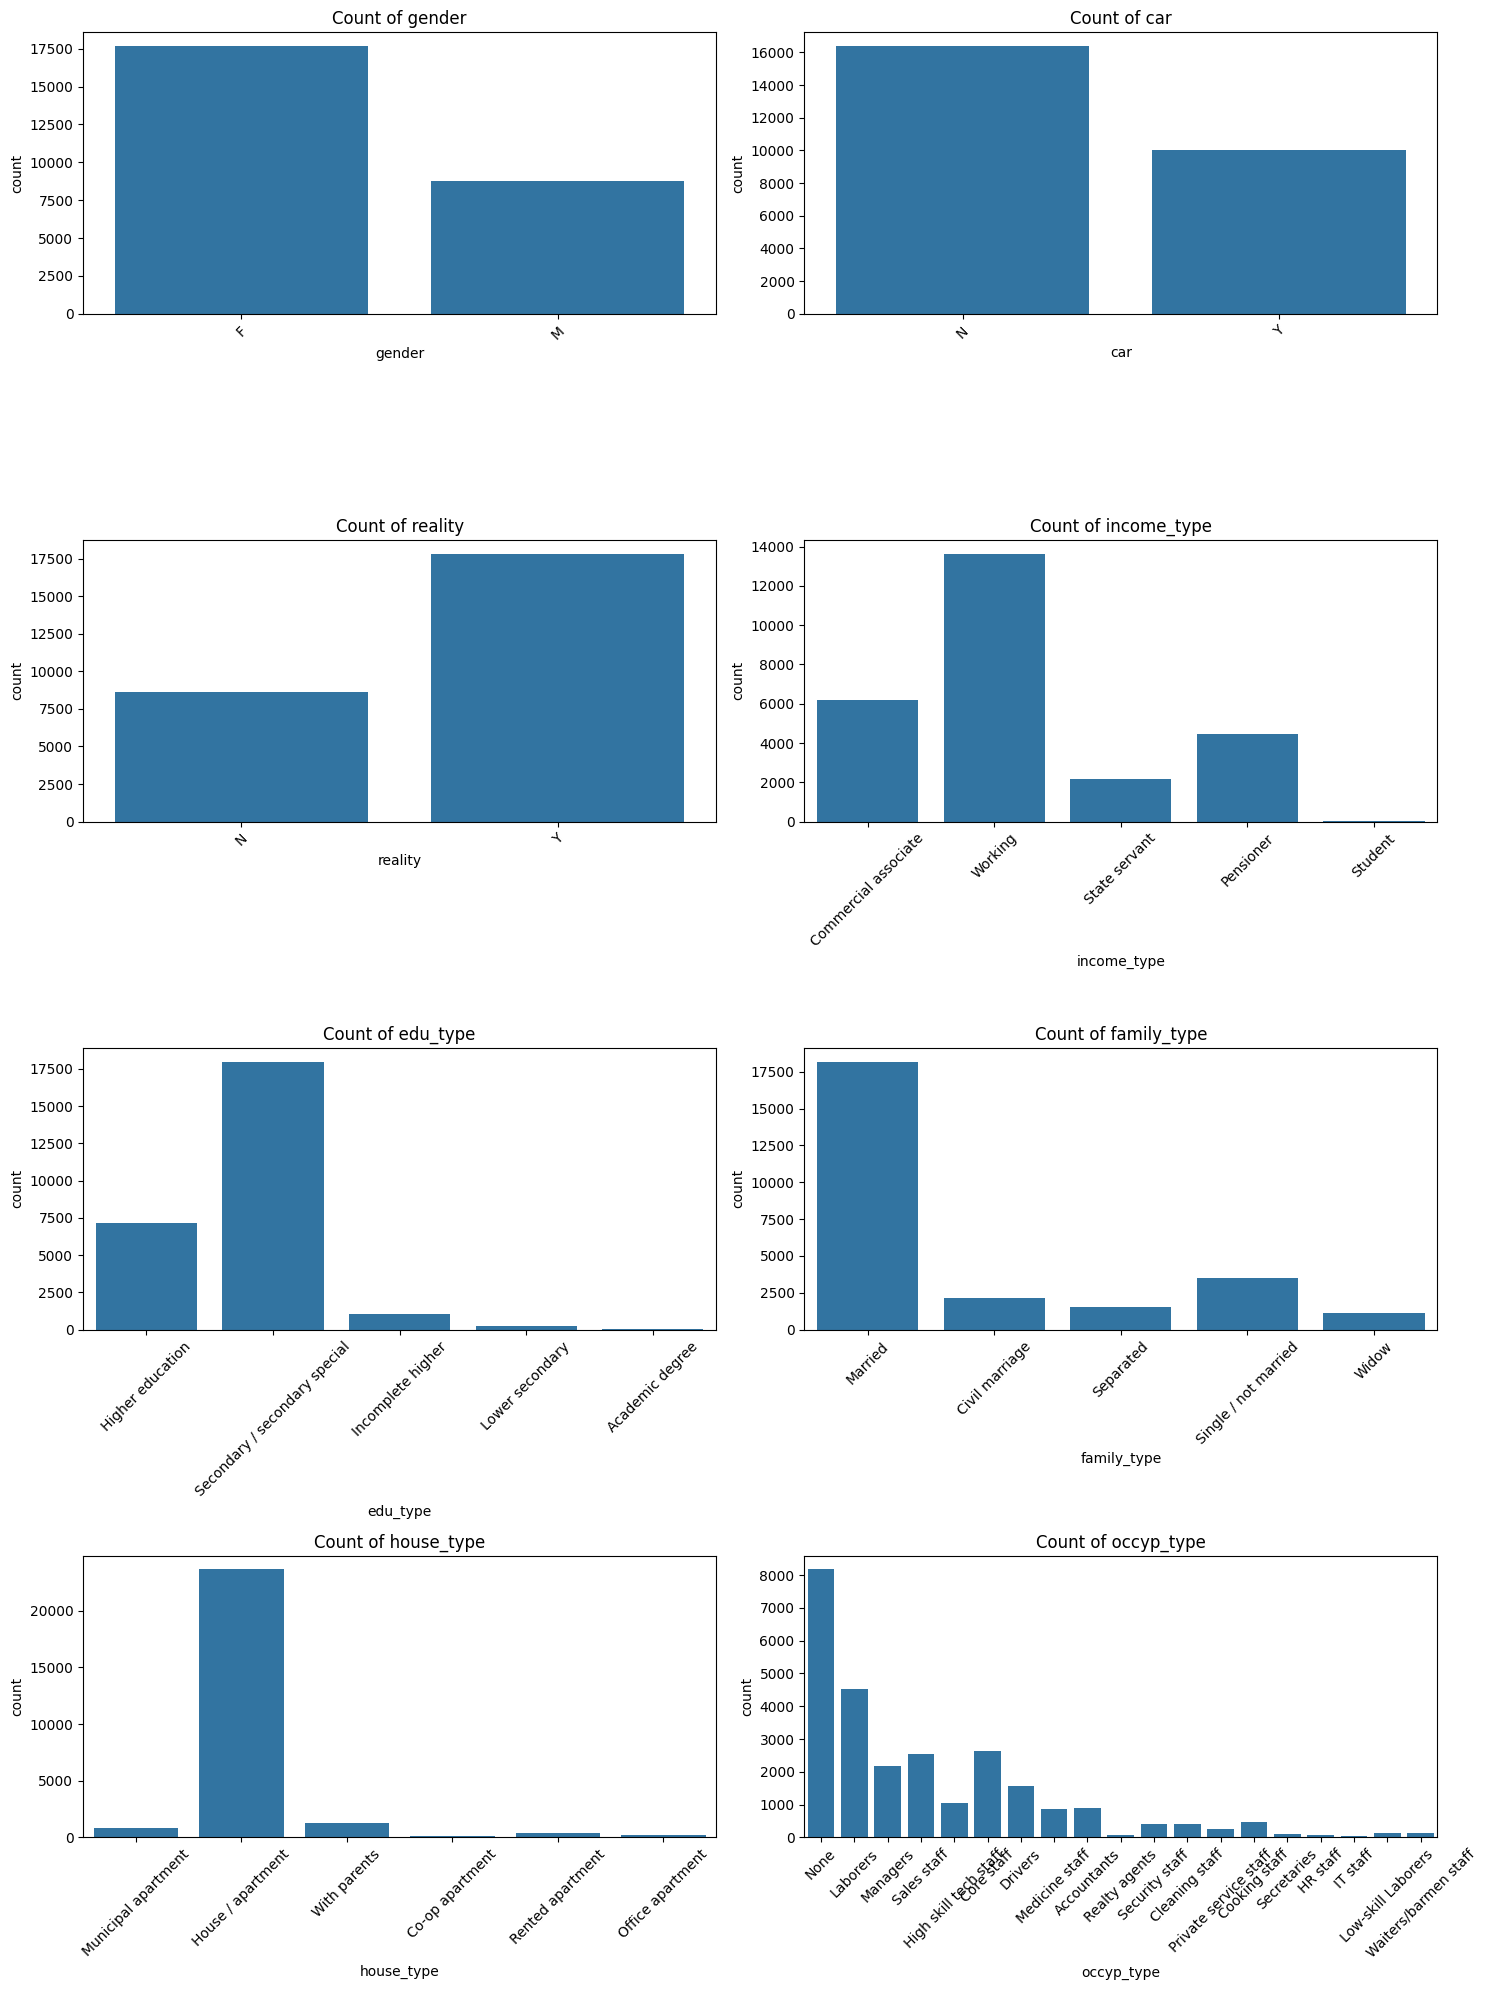

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분포 및 시각화를 위한 설정
plt.figure(figsize=(15, 20))

# 숫자형 변수 분포 확인
numeric_columns = ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'credit']
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col], kde=True)  # 히스토그램과 커널 밀도 추정
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# 범주형 변수 분포 확인
plt.figure(figsize=(15, 20))

categorical_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(4, 2, i)
    sns.countplot(x=col, data=df)  # 막대 그래프
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)  # X축 레이블을 회전하여 가독성 향상

plt.tight_layout()
plt.show()


In [ ]:
# 범주형 변수 라벨 인코딩
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,12,2.0,-6.0,1.0
1,0,0,1,1,247500.0,0,4,0,1,-11380,-1540,1,0,0,1,8,3.0,-5.0,1.0
2,1,1,1,0,450000.0,4,1,1,1,-19087,-4434,1,0,1,0,10,2.0,-22.0,2.0
3,0,0,1,0,202500.0,0,4,1,1,-15088,-2092,1,0,1,0,15,2.0,-37.0,0.0
4,0,1,1,0,157500.0,2,1,1,1,-15037,-2105,1,0,0,0,10,2.0,-26.0,2.0


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

# 데이터 분리
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 데이터를 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 데이터셋과 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 정의
class MultiLayerRegression(nn.Module):
    def __init__(self):
        super(MultiLayerRegression, self).__init__()
        self.linear1 = nn.Linear(X_train.shape[1], 100)
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 100)
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(100, len(set(y)))

    def forward(self, x):
        out1 = self.linear1(x)
        out2 = self.activate1(out1)
        out3 = self.linear2(out2)
        out4 = self.activate2(out3)
        out5 = self.linear3(out4)
        return out5

# 모델, 손실 함수, 옵티마이저 설정
model = MultiLayerRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 조기 종료 변수 설정
patience = 5
best_loss = float('inf')
early_stop_counter = 0

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 검증 손실 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # 조기 종료 확인
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

# 테스트 정확도 계산
model.eval()
with torch.no_grad():
    y_pred = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

Epoch 1/50, Loss: 1.3227, Val Loss: 0.8618
Epoch 2/50, Loss: 1.1923, Val Loss: 0.8384
Epoch 3/50, Loss: 1.1977, Val Loss: 0.8310
Epoch 4/50, Loss: 1.2491, Val Loss: 0.8236
Epoch 5/50, Loss: 1.1725, Val Loss: 0.8191
Epoch 6/50, Loss: 1.1629, Val Loss: 0.8214
Epoch 7/50, Loss: 1.1325, Val Loss: 0.8162
Epoch 8/50, Loss: 1.0812, Val Loss: 0.8197
Epoch 9/50, Loss: 1.0300, Val Loss: 0.8182
Epoch 10/50, Loss: 1.0246, Val Loss: 0.8183
Epoch 11/50, Loss: 0.9519, Val Loss: 0.8196
Epoch 12/50, Loss: 1.0075, Val Loss: 0.8192
Early stopping triggered
Accuracy: 0.6814


### 4. 깃허브 울렁증 격파하기

스토리: 누군가 나에게 분류에는 어떤 모델이 좋다고 써보라고 했다. 그 모델이 뭔진 모르겠다. 그럼에도 불구하고 갖다 써보자

### 1) TabNet 스크립트 버전

---
https://github.com/huangyz0918/tabnet

In [ ]:
!git clone https://github.com/huangyz0918/tabnet

Cloning into 'tabnet'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 33 (delta 11), reused 19 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 10.74 MiB | 7.76 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
!git clone https://github.com/huangyz0918/tabnet

Cloning into 'tabnet'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 33 (delta 11), reused 19 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 10.74 MiB | 5.33 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
%cd tabnet # 작업 디렉토리를 이동

/content/tabnet


In [ ]:
!pwd # 현재 작업디렉토리의 경로를 출력

/content/tabnet


In [ ]:
!python main.py

Traceback (most recent call last):
  File "/content/tabnet/main.py", line 2, in <module>
    import neptune
ModuleNotFoundError: No module named 'neptune'


In [ ]:
!cp -r /content/wine.csv /content/tabnet/data

In [ ]:
!pip install neptune-client==0.9.18

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
  Created wheel for neptune-client: filename=neptune_client-0.9.18-py2.py3-none-any.whl size=420077 sha256=d78375bb0018ac8322763ebdf70a976bc5ec703766523f5fa49f464e71b0752e
  Stored in directory: /root/.cache/pip/wheels/f2/99/34/9085934e30cec49b7cd4010aa4f550b965c57030cdc890f848
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=185622f3322fc441c1bbc9fad2d3b6bb0d39f88f7cd9f519cd3b2692e69

In [ ]:
!pip install sparsemax

In [ ]:
!pip install sparsemax==0.1.9

In [ ]:
!python main.py  #메인에 train valid 싹다 있음. #main.py 로거 싹다 삭제

Device configuration: Cuda not available - check GPU configuration.
Device configuration: Using cpu for training/inference
Starting training...
Training model with predictive objective
Predictive - Epoch: 1, Step: 1, Total train loss: 0.7519, Validation criterion loss: 0.5632, Validation accuracy: 0.7362
Predictive - Epoch: 2, Step: 2, Total train loss: 0.5574, Validation criterion loss: 0.4717, Validation accuracy: 0.82
Predictive - Epoch: 3, Step: 3, Total train loss: 0.4573, Validation criterion loss: 0.3451, Validation accuracy: 0.88
Predictive - Epoch: 4, Step: 4, Total train loss: 0.3454, Validation criterion loss: 0.2385, Validation accuracy: 0.9115
Predictive - Epoch: 5, Step: 5, Total train loss: 0.2711, Validation criterion loss: 0.1748, Validation accuracy: 0.94
Predictive - Epoch: 6, Step: 6, Total train loss: 0.213, Validation criterion loss: 0.1463, Validation accuracy: 0.9492
Predictive - Epoch: 7, Step: 7, Total train loss: 0.1748, Validation criterion loss: 0.125, Vali

In [ ]:
%cd ..

### 2) TabNet 울렁증 버전

---
https://github.com/dreamquark-ai/tabnet


In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score

# 데이터 로드
df = pd.read_csv('wine.csv')

# 특성과 레이블 분리
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# 데이터셋을 훈련 세트와 테스트 세트로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# TabNetClassifier 초기화 및 학습
clf = TabNetClassifier()

# GPU 모드일때
#import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#clf = TabNetClassifier(device_name=device.type)  # GPU 사용 설정

clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

# 예측
preds = clf.predict(X_valid)

# 성능 평가
accuracy = accuracy_score(y_valid, preds)
print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.31352 | val_0_auc: 0.94458 |  0:00:02s
epoch 1  | loss: 0.10203 | val_0_auc: 0.99114 |  0:00:05s
epoch 2  | loss: 0.08551 | val_0_auc: 0.99484 |  0:00:06s
epoch 3  | loss: 0.05907 | val_0_auc: 0.99412 |  0:00:07s
epoch 4  | loss: 0.05207 | val_0_auc: 0.99656 |  0:00:08s
epoch 5  | loss: 0.05124 | val_0_auc: 0.99835 |  0:00:10s
epoch 6  | loss: 0.0477  | val_0_auc: 0.99935 |  0:00:11s
epoch 7  | loss: 0.04294 | val_0_auc: 0.99938 |  0:00:13s
epoch 8  | loss: 0.03777 | val_0_auc: 0.99966 |  0:00:14s
epoch 9  | loss: 0.03198 | val_0_auc: 0.9995  |  0:00:16s
epoch 10 | loss: 0.02692 | val_0_auc: 0.99944 |  0:00:18s
epoch 11 | loss: 0.01987 | val_0_auc: 0.99919 |  0:00:19s
epoch 12 | loss: 0.02677 | val_0_auc: 0.99908 |  0:00:21s
epoch 13 | loss: 0.02331 | val_0_auc: 0.99847 |  0:00:22s
epoch 14 | loss: 0.02111 | val_0_auc: 0.99874 |  0:00:23s
epoch 15 | loss: 0.02229 | val_0_auc: 0.9972  |  0:00:24s
epoch 16 | loss: 0.02312 | val_0_auc: 0.99699 |  0:00:25s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.9938


### 3) TabTransformer 오피셜이 공개되지 않은 버전

---

https://github.com/lucidrains/tab-transformer-pytorch


In [ ]:
!pip install tab-transformer-pytorch

In [ ]:
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('wine.csv')

# 독립 변수와 종속 변수 분리
X = df.drop('class', axis=1).values  # class 열 제외한 나머지 열 사용
y = df['class'].values  # 0 또는 1로 레이블링된 와인 품질

# 데이터셋 분리 (훈련/테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# TabTransformer 모델 정의
model = TabTransformer(
    categories=[],
    num_continuous=X_train_tensor.shape[1],  # 연속형 변수의 개수
    dim=32,  # 모델 차원
    dim_out=1,  # 이진 분류 출력
    depth=6,  # 모델 깊이
    heads=8,  # 멀티헤드 어텐션 헤드 수
    attn_dropout=0.1,  # 어텐션 드롭아웃
    ff_dropout=0.1,  # 피드포워드 드롭아웃
    mlp_hidden_mults=(4, 2),  # MLP의 히든 레이어 크기 비율
    mlp_act=nn.ReLU(),  # MLP의 활성화 함수
)

# 모델 학습 준비
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # 예측 및 손실 계산
    y_pred = model(torch.empty((X_train_tensor.shape[0], 0), dtype=torch.int64), X_train_tensor)  # 범주형 변수가 없으므로 비어있는 텐서를 줘야함.
    loss = criterion(y_pred, y_train_tensor)

    # 역전파 및 최적화
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0 :
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 모델 평가
model.eval()
with torch.no_grad():
    y_pred = model(torch.empty((X_train_tensor.shape[0], 0), dtype=torch.int64), X_test_tensor)
    y_pred = torch.sigmoid(y_pred)
    y_pred_class = (y_pred > 0.5).float()

    accuracy = (y_pred_class == y_test_tensor).float().mean()
    print(f'Valid Accuracy: {accuracy:.4f}')


Epoch 5/50, Loss: 0.7227
Epoch 10/50, Loss: 0.6908
Epoch 15/50, Loss: 0.6619
Epoch 20/50, Loss: 0.6333
Epoch 25/50, Loss: 0.6018
Epoch 30/50, Loss: 0.5647
Epoch 35/50, Loss: 0.5207
Epoch 40/50, Loss: 0.4710
Epoch 45/50, Loss: 0.4176
Epoch 50/50, Loss: 0.3623
Valid Accuracy: 0.9738


### 3) TabTransformer 오피셜이 공개되지 않은 버전 - 타이타닉

---

https://github.com/lucidrains/tab-transformer-pytorch


In [ ]:
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

df = pd.read_csv('titanic.csv')

# 필요한 열 선택 및 전처리
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']]
df.dropna(inplace=True)

# 범주형 변수 인코딩
label_encoders = {}
for col in ['Pclass', 'Sex', 'Embarked']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])


X = df.drop('Survived', axis=1).values  # 'Survived' 열 제외한 나머지 열 사용
y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 연속형 변수만 정규화 적용
scaler = StandardScaler()
X_train[:, [2, 3]] = scaler.fit_transform(X_train[:, [2, 3]])  # 연속형 변수 (Age, Fare)만 정규화
X_test[:, [2, 3]] = scaler.transform(X_test[:, [2, 3]])

X_train_categ = torch.tensor(X_train[:, [0, 1, 4]], dtype=torch.int64)  # 범주형 변수 (Pclass, Sex, Embarked)
X_train_cont = torch.tensor(X_train[:, [2, 3]], dtype=torch.float32)  # 연속형 변수 (Age, Fare)
X_test_categ = torch.tensor(X_test[:, [0, 1, 4]], dtype=torch.int64)
X_test_cont = torch.tensor(X_test[:, [2, 3]], dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# TabTransformer 모델 정의
model = TabTransformer(
    categories=(3, 2, 3),  # Pclass, Sex, Embarked의 고유 값 개수
    num_continuous=X_train_cont.shape[1],  # 연속형 변수의 개수
    dim=32,  # 모델 차원
    dim_out=1,  # 이진 분류 출력
    depth=6,  # 모델 깊이
    heads=8,  # 멀티헤드 어텐션 헤드 수
    attn_dropout=0.1,  # 어텐션 드롭아웃
    ff_dropout=0.1,  # 피드포워드 드롭아웃
    mlp_hidden_mults=(4, 2),  # MLP의 히든 레이어 크기 비율
    mlp_act=nn.ReLU(),  # MLP의 활성화 함수
)

# 모델 학습 준비
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # 예측 및 손실 계산
    y_pred = model(X_train_categ, X_train_cont)  # 범주형 및 연속형 변수 모두 전달
    loss = criterion(y_pred, y_train_tensor)

    # 역전파 및 최적화
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 모델 평가
model.eval()
with torch.no_grad():
    y_pred = model(X_test_categ, X_test_cont)
    y_pred = torch.sigmoid(y_pred)
    y_pred_class = (y_pred > 0.5).float()

    accuracy = (y_pred_class == y_test_tensor).float().mean()
    print(f'Valid Accuracy: {accuracy:.4f}')


ModuleNotFoundError: No module named 'tab_transformer_pytorch'

# ★ 실무 실습) 배포 받은 "Loan-Status-Prediction"를 통해 자신만의 코드를 작성 해보자

1. 대출자가 상환할 가능성이 있는지를 분류하는 모델을 만들 것이다.
2. 하나의 포트폴리오가 될 수 있도록 시각화와 통계를 자유롭게 작성해보자.
3. 이제까지 배운 분류 방법들을 통해 적용해보자.
4. 모든 기법을 다 쓰는 것보다는 필요 할 것 같다는 코드만 작성해보기


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score
df = pd.read_csv('Loan Status Prediction.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


###  위 코드에서 어떤 기법들을 썼었고 왜 그것들을 썼는지 서술 하시오.